**Lesson: M931LT1 Artificial Intelligence II**

**Student's name: Christina Christodoulou**

**I.D Number: lt1200027**

**Field of Studies: Language Technology**

**Homework 3**


**SENTIMENT ANALYSIS OF TWEETS USING BIDIRECTIONAL RNN**

**VACCINE SENTIMENT CLASSIFIER**

In [1]:
# Import necessary libraries
import re 
import torch
import random
import spacy
import matplotlib.pyplot as plt 
import pandas as pd  
import pickle
import math
import nltk
import time
import numpy as np
from tqdm import tqdm
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import collections
from sklearn.utils import resample
from sklearn import metrics
from sklearn.model_selection import learning_curve
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.preprocessing import label_binarize
from numpy import interp
from itertools import cycle
from sklearn.metrics import roc_curve, auc, classification_report
from torch.utils.data import TensorDataset
import torch.nn as nn
import torchtext
from torchtext.legacy import data
import torchtext.legacy
import torch.nn.functional as F
import torch.optim as optim

# Download necessary packages
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
stop_words_set = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [2]:
# Download and unzip the Glove pre-trained vectors in a new folder to use as embeddings
FILE = 'GLOVE'
URL = 'http://nlp.stanford.edu/data/glove.twitter.27B.zip'

!wget -P $FILE $URL
!unzip $FILE/glove*.zip -d $FILE

--2022-01-26 12:20:29--  http://nlp.stanford.edu/data/glove.twitter.27B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.twitter.27B.zip [following]
--2022-01-26 12:20:29--  https://nlp.stanford.edu/data/glove.twitter.27B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.twitter.27B.zip [following]
--2022-01-26 12:20:30--  http://downloads.cs.stanford.edu/nlp/data/glove.twitter.27B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1520408563 (1.4G) [appli

In [3]:
# Set up GPU for Training
if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device('cpu')

There are 1 GPU(s) available.
Device name: Tesla K80


In [4]:
# A function that calculates the time needed for training and evaluation in each epoch
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [5]:
# A function that opens, reads a file in csv with utf-8 encoding, gets the values, checks and fills empty values and checks for duplicates
def read_explore_dataframe(csv_file):
  
  # Open and read the csv file with utf-8 encoding
  dataframe = pd.read_csv(csv_file,encoding='utf-8')
  
  # Get the keys and their corresponding number of values
  keys = dataframe.keys() 
  for key in keys:
    df_len = len(dataframe[key].unique()) # the length of the unique values of each column
    print('{0:25}{1:10}'.format(key,df_len))

  dataframe.dropna(inplace=True) # remove missing values and keep the dataFrame with valid entries in the same variable
  dataframe.reset_index(inplace=True,drop=True)

  dataframe.duplicated() # check for duplicates
  #print('Number of duplicates in the dataframe:', dataframe.duplicated().sum())
  print('Dataframe checked for NaN values and duplicates!')
  
  return dataframe 

In [6]:
# A function that takes as parameter a text and applies pre-processing steps to clean it
def text_preprocessing(text):
  
  # Remove tags
  TAG_RE = re.compile(r'<[^>]+>')
  no_tags = TAG_RE.sub('',text)  
                
  # Remove unusual characters
  text = re.sub('<[^>]*>', '', no_tags)

  # Remove urls
  text = re.sub(r'http\S+','', text)
    
  # Remove emoticons
  emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)

  # Remove punctuation
  no_punct = [word for word in emoticons if word.isalpha()]
                
  # Convert all words to lowercase
  text = re.sub('[\W]+', ' ', text.lower()) + " ".join(no_punct).replace('-', '')
    
  # Remove numbers
  no_numbers_txt = re.sub(r'\d+', '', text)

  # Tokenize
  tokens = nltk.word_tokenize(no_numbers_txt)

  # Lemmatize
  lemmatizer = WordNetLemmatizer()
  lemmas = " ".join([lemmatizer.lemmatize(token) for token in tokens])
  
  return lemmas

In [7]:
# A function that gets as input the dataframe and gets the necessary values from the columns after resampling and pre-processing
def get_columns(dataframe, feature, label):
  
  # Get only the columns we are interested in
  dataset = dataframe[[feature,label]]
  
  # Check the distribution of classes
  distribution = dataset[label].value_counts()/dataset.shape[0]
  print('Distribution of data in classes:')
  print(distribution)

  # Separate the different labels and create a combined dataset
  neutral = dataset[dataset[label] == 0]
  antivax = dataset[dataset[label] == 1]
  provax = dataset[dataset[label] == 2]

  # Combine the classes with the greater number of values
  class_majorities = pd.concat([neutral,provax])
  classes = pd.concat([neutral,antivax,provax])

  # Upsampling: take samples with replacement from the minority class until the class is almost the same size as the majorities
  train_minority_upsampled = resample(antivax, replace=True, n_samples=len(classes),random_state=123)
  train_minority_upsampled2 = resample(neutral, replace=True, n_samples=len(classes),random_state=123)
  train_minority_upsampled3 = resample(provax, replace=True, n_samples=len(classes),random_state=123)
  
  # Combine in a new dataframe the new resampled classes 
  dataset = pd.concat([train_minority_upsampled,train_minority_upsampled2,train_minority_upsampled3]) 
  print('Distribution of data in classes after resampling:')
  print(dataset[label].value_counts())
  
  # Apply the pre-processing function to the dataframe containing the text (feature column)
  dataset[feature] = dataset[feature].apply(text_preprocessing)
  print('\nText done pre-processing!')

  # Divide the X and y values
  X = dataset[feature]
  y = dataset[label]

  # Concatenate the X,Y data
  new_dataframe = pd.concat([X, y], axis=1)
     
  return new_dataframe

In [8]:
# A function that creates iterators for the given datasets
# In each batch, the sentences are transposed to be descending vertically 
# Each index represents a token and each column represents a sentence
# The batch size specifies the number of columns
# The lambda function finds sentences of the same length
 
def create_iterators(train_dataset, validation_dataset, batch_size):
  
  train_iterator, val_iterator = data.BucketIterator.splits(
  # The Datasets to load Examples from
  (train_dataset, validation_dataset), 
  # The batch size
  batch_size = batch_size,
  # Function to use for sorting examples
  sort_key = lambda x: len(x.Tweet),
  # Repeat the iterator for multiple epochs
  repeat = False,
  # Shuffle data on each epoch run
  shuffle = True,
  # Use 'sort_key' to sort examples in each batch
  sort_within_batch = True,
  device = device)
  
  return train_iterator, val_iterator

In [9]:
# A function that calculates the trainable parameters of the model
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# A function that sets seed for reproducibility
def set_seed(seed_value): 
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

In [10]:
# Calculates the accuracy per batch, used in the train_model and evaluate_model functions 
def accuracy(preds, y_true):
  
  y_pred = torch.round(preds)
  _,pred_label = torch.max(y_pred, dim = 1)
  
  correct = (pred_label == y_true).float()
  acc = correct.sum() / len(correct)
  
  return acc

In [11]:
# A function that calculates all the metrics using the validation/test set
def calculate_metrics(y_true, preds):  
  
  print('\nCalculating metrics...')
  
  # Calculate the accuracy of the model 
  acc = accuracy_score(y_true, preds)
  
  # Calculate general precision, recall, F1 score of the model and of each class
  precision, recall, fscore, support = score(y_true, preds)
  print('Accuracy: {}'.format(acc))
  print('Precision: {}'.format(precision))
  print('Recall: {}'.format(recall))
  print('F1 score: {}'.format(fscore))
  print('Support: {}'.format(support))

  # Print classification report
  print(classification_report(y_true, preds))

In [12]:
# ====== Training (Train data) ======
def train(model, iterator, optimizer, criterion, clip):
  
  training_loss = 0   
  training_acc = 0
    
  # Set model to training mode
  model.train()
   
  # For each batch in the training iterator
  for batch in tqdm(iterator):
   
    # Zero the gradients
    optimizer.zero_grad()
        
    # batch.Tweet is a tuple (tensor, len of seq)           
    text, text_lengths = batch.Tweet
            
    # Compute the predictions
    predictions = model(text,text_lengths).squeeze(1)   
    
    # Compute the loss
    loss = criterion(predictions, batch.Label.long())
        
    # Compute the accuracy
    acc = accuracy(predictions, batch.Label.float())
        
    # Use loss to compute gradients
    loss.backward()
    
    # Clip the gradient value
    nn.utils.clip_grad_norm_(model.parameters(), clip)
        
    # Use optimizer to take gradient step
    optimizer.step()
        
    training_loss += loss.item()
    training_acc += acc.item()
  
  loss_of_epoch = training_loss / len(iterator)
  accuracy_of_epoch = training_acc / len(iterator)
  
  # Return the loss and accuracy, averaged across each epoch
  # len of iterator = number of batches in the iterator
  return loss_of_epoch, accuracy_of_epoch

In [13]:
# ====== Evaluation (validation data) ======
def evaluate(model, iterator, criterion):
       
  eval_loss = 0
  eval_acc = 0
    
  # Set model to evaluation mode
  model.eval()
   
  # Don't calculate the gradients
  with torch.no_grad():
    
    for batch in tqdm(iterator):
     
      # batch.Tweet is a tuple (tensor, len of seq)
      text, text_lengths = batch.Tweet

      # Compute the predictions         
      predictions = model(text, text_lengths).squeeze(1)

      # Compute the loss    
      loss = criterion(predictions, batch.Label.long())

      # Compute the accuracy    
      acc = accuracy(predictions, batch.Label.float())

      eval_loss += loss.item()
      eval_acc += acc.item()
        
  loss_of_epoch = eval_loss / len(iterator)
  accuracy_of_epoch = eval_acc / len(iterator)

  # Return the loss and accuracy, averaged across each epoch
  # len of iterator = number of batches in the iterator
  return loss_of_epoch, accuracy_of_epoch


def testing(model, iterator):
    
  predictions_all = []
  labels_all = []
    
  model.eval() 
    
  with torch.no_grad():   
    for batch in iterator:      
      for label in batch.Label:
        labels = label.flatten().cpu().numpy().tolist()
        labels_all.append(labels)              
      text, text_lengths = batch.Tweet     
      predictions = model(text, text_lengths).squeeze(1)            
      output = (torch.argmax(predictions, dim = 1)).data.cpu().numpy()      
      predictions_all.extend(output)
        
  return predictions_all, labels_all

In [14]:
class BIDIRECTIONAL_RNN_LSTM_GRU(nn.Module):
  
  def __init__(self, cell_type, input_size, embedding_size, hidden_size, output_size, embeddings, num_layers, dropout, pad_idx):
    super(BIDIRECTIONAL_RNN_LSTM_GRU, self).__init__()

    cells = {'LSTM': nn.LSTM, 'GRU': nn.GRU}   

    # Initializations
    self.cell_type = cell_type
    self.input_size = input_size
    self.embedding_size = embedding_size
    self.hidden_size = hidden_size
    self.output_size = output_size  
    self.num_layers = num_layers
    self.dropout = dropout
     
    # Feed the tweets in the embedding layer
    # padding_idx set to not learn the embedding for the <pad> token - irrelevant to determining sentiment 
    self.word_embeddings = nn.Embedding(input_size, embedding_size, padding_idx = pad_idx)
    
    assert cell_type in cells, 'Use one of the following: {}'.format(str(cells))
    rnn_cell = getattr(nn, cell_type) # It fetches the constructor from torch.nn
    self.rnn = rnn_cell(
        input_size = self.embedding_size,   # Number of features for each time step        
        num_layers = self.num_layers,       # If the number of layers is bigger than 1, then it is a stacked RNN)
        hidden_size = self.hidden_size,     # LSTM/GRU hidden embedding representation
        batch_first = True,                 # Input and output's batch size: (batch, time_step, input_size) => 1st dimension
        bidirectional = True,               # It is a bidirectional RNN
        dropout = self.dropout)             # Dropout regularization  
                
    # Final hidden state has both a forward and a backward component concatenated together
    # The size of the input to the nn.Linear layer is twice that of the hidden dimension size
    self.predictor = nn.Linear(hidden_size*2, output_size)

    # Initialize dropout layer for regularization
    self.dropout = nn.Dropout(dropout)

    # Initialize RELU activation function
    self.relu = nn.ReLU()

  def forward(self, text, text_lengths):
        
    # Text - [tweet length, batch size]
    # Text_lengths - lengths of tweet
        
    # Embedded = [sentence len, batch size, emb dim] with dropout 
    embedded = self.dropout(self.word_embeddings(text))    

    # Pack the embeddings to only process non-padded elements, it speeds up computation
    packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.to('cpu'))

    if self.cell_type == 'LSTM':
      packed_output, (hidden, cell) = self.rnn(packed_embedded)
    if self.cell_type == 'GRU':
      packed_output, hidden = self.rnn(packed_embedded)

    # Unpack the sequence - transform packed sequence to a tensor
    output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)

    # Output = [sentence len, batch size, hid dim * num directions]
    # Output over padding tokens are zero tensors
        
    # Hidden = [num layers * num directions, batch size, hid dim]
    # Cell = [num layers * num directions, batch size, hid dim]
        
    # Get the final layer forward and backward hidden states  
    # Concat the final forward and backward hidden layers and apply dropout
    hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
       
    return self.predictor(self.relu(hidden))

**1. BIDIRECTIONAL STACKED RNN WITH LSTM/GRU CELLS FOR THE TWITTER VACCINE SENTIMENT DATASET**

In [48]:
# STACKED RNN WITH LSTM
def train_evaluate_bidirectional_RNN_model_LSTM(TEXT, data_train, data_val):
  
  # -----Initialize the model and its parameters-----

  # The number of words in the vocabulary
  input_dim = len(TEXT.vocab)
  # The dimensions of each Glove vector              
  embedding_dim = 25                       
  # The number of hidden neurons
  hidden_dim = 20          
  # The number of output layers
  output_dim = 3                           
  # The number of hidden layers
  num_layers = 2                                        
  # Cell type of model
  cell_type = 'LSTM'                       
  # Dropout
  dropout = 0.5              
  # The Glove pre-trained embeddings
  embeddings = TEXT.vocab.vectors          
  # Get pad token index from vocab
  PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

  # Initialize the model parameters
  num_epochs = 40
  batch_size = 256
  clip = 2
    
  # Instantiate the model 
  model = BIDIRECTIONAL_RNN_LSTM_GRU(cell_type, input_dim, embedding_dim, hidden_dim, output_dim, embeddings, num_layers, dropout, PAD_IDX)
  print(model)  
  print(f'The model has {count_parameters(model):,} trainable parameters')

  # Replace the initial weights of the embedding layer with the Glove pre-trained embeddings
  model.word_embeddings.weight.data.copy_(embeddings)
  # Initialize <unk> and <pad> both to all zeros - irrelevant for sentiment analysis
  UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

  # Setting row in the embedding weights matrix to zero using the token index
  model.word_embeddings.weight.data[UNK_IDX] = torch.zeros(embedding_dim)
  model.word_embeddings.weight.data[PAD_IDX] = torch.zeros(embedding_dim)
  #print(model.word_embeddings.weight.data)

  # Define the optimizer
  optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001, weight_decay = 1e-4)   

  # Define loss function
  loss_function = nn.CrossEntropyLoss()
  
  model = model.to(device)
  loss_function = loss_function.to(device)
  
  #set_seed(42)

  # Create the iterators used for training and evaluating the model
  train_iterator, valid_iterator = create_iterators(data_train, data_val, batch_size)

  best_valid_loss = float('inf')

  # Initialize empty lists to store the values of loss and accuracy for each epoch
  train_accuracies = []
  train_losses = []
  val_accuracies = []
  val_losses = []
  
  for epoch in range(num_epochs):
    
    start_time = time.time()

    train_loss, train_accuracy = train(model, train_iterator, optimizer, loss_function, clip)
    validation_loss, validation_accuracy = evaluate(model, valid_iterator, loss_function)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
      
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_accuracy*100:.2f}%')
    print(f'\t Val. Loss: {validation_loss:.3f} |  Val. Acc: {validation_accuracy*100:.2f}%')
      
    if validation_loss < best_valid_loss:
        best_valid_loss = validation_loss
        torch.save(model.state_dict(), 'LSTM_model.pt')

    # Fill the empty lists with the values of accuracy and loss for training and evaluation sets
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(validation_loss)
    val_accuracies.append(validation_accuracy)

  # Plot the loss vs epochs 
  plt.plot(train_losses)
  plt.plot(val_losses)
  plt.title('Train vs Validation Model Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'])
  plt.show()

  # Plot the accuracy vs epochs
  plt.plot(train_accuracies)
  plt.plot(val_accuracies)
  plt.title('Train vs Validation Model Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'])
  plt.show()
   
  # Evaluate model on the validation set
  predictions, labels = testing(model, valid_iterator)

  # Calculate the evaluation metrics on the testing set    
  calculate_metrics(labels, predictions)                        

  # Label binarization and store the number of classes
  y_test = label_binarize(labels, classes=[0, 1, 2])
  n_classes = y_test.shape[1]

  # Label binarization and store the number of classes
  y_score = label_binarize(predictions, classes=[0, 1, 2])

  # Compute ROC curve and ROC area for each class
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

  # Compute micro-average ROC curve and ROC area
  fpr['micro'], tpr['micro'], _ = roc_curve(y_test.ravel(), y_score.ravel())
  roc_auc['micro'] = auc(fpr['micro'], tpr['micro'])

  # First aggregate all false positive rates
  all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

  # Then interpolate all ROC curves at this points
  mean_tpr = np.zeros_like(all_fpr)
  for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

  # Finally average it and compute AUC
  mean_tpr /= n_classes

  fpr['macro'] = all_fpr
  tpr['macro'] = mean_tpr
  roc_auc['macro'] = auc(fpr['macro'], tpr['macro'])
  lw = 2

  # Plot all ROC curves
  plt.figure()
  plt.plot(
    fpr['micro'],
    tpr['micro'],
    label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc['micro']),
    color='deeppink',
    linestyle=':',
    linewidth=4,)

  plt.plot(
    fpr['macro'],
    tpr['macro'],
    label='macro-average ROC curve (area = {0:0.2f})'.format(roc_auc['macro']),
    color='navy',
    linestyle=':',
    linewidth=4,)

  colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
  for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label= 'ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]),)

  plt.plot([0, 1], [0, 1], "k--", lw=lw)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Roc curve for all classes')
  plt.legend(loc='lower right')
  plt.show()

In [52]:
# STACKED RNN WITH GRU
def train_evaluate_bidirectional_RNN_model_GRU(TEXT, data_train, data_val):
  
  # -----Initialize the model and its parameters-----
  # The number of words in the vocabulary
  input_dim = len(TEXT.vocab)
  # The dimensions of each Glove vector              
  embedding_dim = 25                       
  # The number of hidden neurons
  hidden_dim = 20                    
  # The number of output layers
  output_dim = 3                           
  # The number of hidden layers
  num_layers = 2                                           
  # Cell type of model
  cell_type = 'GRU'                       
  # Dropout
  dropout = 0.5                
  # The Glove pre-trained embeddings
  embeddings = TEXT.vocab.vectors          
  # Get pad token index from vocab
  PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

  # Initialize the model parameters
  num_epochs = 40
  batch_size = 256
  clip = 2
    
  # Instantiate the model 
  model = BIDIRECTIONAL_RNN_LSTM_GRU(cell_type, input_dim, embedding_dim, hidden_dim, output_dim, embeddings, num_layers, dropout, PAD_IDX)
  print(model)
  model = model.to(device)
  print(f'The model has {count_parameters(model):,} trainable parameters')

  # Replace the initial weights of the embedding layer with the pre-trained embeddings
  model.word_embeddings.weight.data.copy_(embeddings)
  # Initialize <unk> and <pad> both to all zeros - irrelevant for sentiment analysis
  UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

  # Setting row in the embedding weights matrix to zero using the token index
  model.word_embeddings.weight.data[UNK_IDX] = torch.zeros(embedding_dim)
  model.word_embeddings.weight.data[PAD_IDX] = torch.zeros(embedding_dim)
  #print(model.embedding.weight.data)

  # Define the optimizer
  optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001, weight_decay = 1e-4)   
  
  # Define loss function
  loss_function = nn.CrossEntropyLoss()
  loss_function = loss_function.to(device)

  #set_seed(42)

  # Create the iterators used for training and evaluating the model
  train_iterator, valid_iterator = create_iterators(data_train, data_val, batch_size)

  best_valid_loss = float('inf')

  # Initialize empty lists to store the values of loss and accuracy for each epoch
  train_accuracies = []
  train_losses = []
  val_accuracies = []
  val_losses = []
  
  for epoch in range(num_epochs):
    
    start_time = time.time()

    train_loss, train_accuracy = train(model, train_iterator, optimizer, loss_function, clip)
    validation_loss, validation_accuracy = evaluate(model, valid_iterator, loss_function)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
      
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_accuracy*100:.2f}%')
    print(f'\t Val. Loss: {validation_loss:.3f} |  Val. Acc: {validation_accuracy*100:.2f}%')
      
    if validation_loss < best_valid_loss:
        best_valid_loss = validation_loss
        torch.save(model.state_dict(), 'GRU_model.pt')

    # Fill the empty lists with the values of accuracy and loss for training and evaluation sets
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(validation_loss)
    val_accuracies.append(validation_accuracy)

  # Plot the loss vs epochs 
  plt.plot(train_losses)
  plt.plot(val_losses)
  plt.title('Train vs Validation Model Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'])
  plt.show()

  # Plot the accuracy vs epochs
  plt.plot(train_accuracies)
  plt.plot(val_accuracies)
  plt.title('Train vs Validation Model Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'])
  plt.show()

  # Evaluate model on the validation set
  predictions, labels = testing(model, valid_iterator)

  # Calculate the evaluation metrics on the testing set    
  calculate_metrics(labels, predictions)                        

  # Label binarization and store the number of classes
  y_test = label_binarize(labels, classes=[0, 1, 2])
  n_classes = y_test.shape[1]

  # Label binarization and store the number of classes
  y_score = label_binarize(predictions, classes=[0, 1, 2])

  # Compute ROC curve and ROC area for each class
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

  # Compute micro-average ROC curve and ROC area
  fpr['micro'], tpr['micro'], _ = roc_curve(y_test.ravel(), y_score.ravel())
  roc_auc['micro'] = auc(fpr['micro'], tpr['micro'])

  # First aggregate all false positive rates
  all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

  # Then interpolate all ROC curves at this points
  mean_tpr = np.zeros_like(all_fpr)
  for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

  # Finally average it and compute AUC
  mean_tpr /= n_classes

  fpr['macro'] = all_fpr
  tpr['macro'] = mean_tpr
  roc_auc['macro'] = auc(fpr['macro'], tpr['macro'])
  lw = 2

  # Plot all ROC curves
  plt.figure()
  plt.plot(
    fpr['micro'],
    tpr['micro'],
    label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc['micro']),
    color='deeppink',
    linestyle=':',
    linewidth=4,)

  plt.plot(
    fpr['macro'],
    tpr['macro'],
    label='macro-average ROC curve (area = {0:0.2f})'.format(roc_auc['macro']),
    color='navy',
    linestyle=':',
    linewidth=4,)

  colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
  for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label= 'ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]),)

  plt.plot([0, 1], [0, 1], "k--", lw=lw)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Roc curve for all classes')
  plt.legend(loc='lower right')
  plt.show()

**DATA PREPARATION**

In [17]:
# Prepare the training dataset
print('------ Preparing the training dataset... ------')

# Opens, reads, checks for duplicates and removes missing values
df_train  = read_explore_dataframe('vaccine_train_set.csv')

# Preprocess and resample dataset and return a new cleaned one 
train_dataframe = get_columns(df_train, 'tweet', 'label')
  
# Save the testing data into csv format 
train_dataframe.to_csv("/content/train.csv", index=False)
print('The training dataset is ready and saved into csv format!')

# Prepare the validation dataset
print('\n------ Preparing the validation dataset... ------')

# Opens, reads, checks for duplicates and removes missing values
df_val = read_explore_dataframe('vaccine_validation_set.csv')

# Preprocess and resample dataset and return a new cleaned one 
valid_dataframe = get_columns(df_val, 'tweet', 'label')
  
# Save the testing data into csv format 
valid_dataframe.to_csv("/content/validation.csv", index=False)
print('The validation dataset is ready and saved into csv format!')

------ Preparing the training dataset... ------
Unnamed: 0                    15976
tweet                         15881
label                             3
Dataframe checked for NaN values and duplicates!
Distribution of data in classes:
0    0.466825
2    0.403418
1    0.129757
Name: label, dtype: float64
Distribution of data in classes after resampling:
2    15976
1    15976
0    15976
Name: label, dtype: int64

Text done pre-processing!
The training dataset is ready and saved into csv format!

------ Preparing the validation dataset... ------
Unnamed: 0                     2282
tweet                          2276
label                             3
Dataframe checked for NaN values and duplicates!
Distribution of data in classes:
0    0.466696
2    0.403593
1    0.129711
Name: label, dtype: float64
Distribution of data in classes after resampling:
2    2282
1    2282
0    2282
Name: label, dtype: int64

Text done pre-processing!
The validation dataset is ready and saved into csv form

**BUILD THE VOCABULARY**

In [18]:
set_seed(42)

# Create the TEXT and LABEL fields
TEXT = data.Field(tokenize = 'spacy', lower = True, sequential = True, include_lengths = True)
LABEL = data.LabelField(dtype = torch.float, sequential = False)

# Loading training and validation data 
train_data, valid_data = data.TabularDataset.splits(
    path ='/content/', train = 'train.csv', 
    validation = 'validation.csv', format = 'csv', skip_header = True, 
    fields = [('Tweet', TEXT), ('Label', LABEL)])

print(f'Number of training examples: {len(train_data)}')
print(f'Number of valid examples: {len(valid_data)}')

# Build the vocabulary using the train data
TEXT.build_vocab(train_data, vectors = torchtext.vocab.Vectors('/content/GLOVE/glove.twitter.27B.25d.txt'), unk_init=torch.Tensor.normal_) 
LABEL.build_vocab(train_data)

print('\nTokens in TEXT vocabulary: {}'.format(len(TEXT.vocab)))
print('Tokens in LABEL vocabulary: {}'.format(len(LABEL.vocab)))

Number of training examples: 47928
Number of valid examples: 6846


100%|█████████▉| 1193513/1193514 [00:28<00:00, 41429.05it/s]



Tokens in TEXT vocabulary: 20872
Tokens in LABEL vocabulary: 3


**BIDIRECTIONAL STACKED RNN WITH LSTM**

BIDIRECTIONAL_RNN_LSTM_GRU(
  (word_embeddings): Embedding(20872, 25, padding_idx=1)
  (rnn): LSTM(25, 20, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (predictor): Linear(in_features=40, out_features=3, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (relu): ReLU()
)
The model has 539,363 trainable parameters


100%|██████████| 27/27 [00:00<00:00, 87.18it/s] 


Epoch: 01 | Epoch Time: 0m 6s
	Train Loss: 1.103 | Train Acc: 33.22%
	 Val. Loss: 1.099 |  Val. Acc: 33.06%


100%|██████████| 27/27 [00:00<00:00, 85.17it/s] 


Epoch: 02 | Epoch Time: 0m 6s
	Train Loss: 1.099 | Train Acc: 33.25%
	 Val. Loss: 1.096 |  Val. Acc: 33.06%


100%|██████████| 27/27 [00:00<00:00, 86.99it/s] 


Epoch: 03 | Epoch Time: 0m 6s
	Train Loss: 1.097 | Train Acc: 33.22%
	 Val. Loss: 1.091 |  Val. Acc: 33.06%


100%|██████████| 27/27 [00:00<00:00, 86.86it/s] 


Epoch: 04 | Epoch Time: 0m 6s
	Train Loss: 1.092 | Train Acc: 33.23%
	 Val. Loss: 1.082 |  Val. Acc: 33.06%


100%|██████████| 27/27 [00:00<00:00, 88.23it/s] 


Epoch: 05 | Epoch Time: 0m 6s
	Train Loss: 1.082 | Train Acc: 33.24%
	 Val. Loss: 1.060 |  Val. Acc: 33.06%


100%|██████████| 27/27 [00:00<00:00, 73.92it/s]


Epoch: 06 | Epoch Time: 0m 6s
	Train Loss: 1.063 | Train Acc: 33.96%
	 Val. Loss: 1.024 |  Val. Acc: 33.06%


100%|██████████| 27/27 [00:00<00:00, 84.99it/s]


Epoch: 07 | Epoch Time: 0m 7s
	Train Loss: 1.040 | Train Acc: 36.84%
	 Val. Loss: 0.990 |  Val. Acc: 33.26%


100%|██████████| 27/27 [00:00<00:00, 85.68it/s] 


Epoch: 08 | Epoch Time: 0m 7s
	Train Loss: 1.018 | Train Acc: 40.18%
	 Val. Loss: 0.971 |  Val. Acc: 41.01%


100%|██████████| 27/27 [00:00<00:00, 85.21it/s] 


Epoch: 09 | Epoch Time: 0m 6s
	Train Loss: 1.003 | Train Acc: 42.20%
	 Val. Loss: 0.940 |  Val. Acc: 47.85%


100%|██████████| 27/27 [00:00<00:00, 84.65it/s] 


Epoch: 10 | Epoch Time: 0m 6s
	Train Loss: 0.987 | Train Acc: 44.10%
	 Val. Loss: 0.922 |  Val. Acc: 49.66%


100%|██████████| 27/27 [00:00<00:00, 86.07it/s] 


Epoch: 11 | Epoch Time: 0m 6s
	Train Loss: 0.975 | Train Acc: 45.58%
	 Val. Loss: 0.912 |  Val. Acc: 49.84%


100%|██████████| 27/27 [00:00<00:00, 86.61it/s] 


Epoch: 12 | Epoch Time: 0m 6s
	Train Loss: 0.965 | Train Acc: 46.66%
	 Val. Loss: 0.896 |  Val. Acc: 51.94%


100%|██████████| 27/27 [00:00<00:00, 85.42it/s] 


Epoch: 13 | Epoch Time: 0m 6s
	Train Loss: 0.958 | Train Acc: 47.45%
	 Val. Loss: 0.888 |  Val. Acc: 52.21%


100%|██████████| 27/27 [00:00<00:00, 89.00it/s] 


Epoch: 14 | Epoch Time: 0m 6s
	Train Loss: 0.949 | Train Acc: 48.25%
	 Val. Loss: 0.885 |  Val. Acc: 51.60%


100%|██████████| 27/27 [00:00<00:00, 86.61it/s] 


Epoch: 15 | Epoch Time: 0m 6s
	Train Loss: 0.940 | Train Acc: 49.14%
	 Val. Loss: 0.875 |  Val. Acc: 53.81%


100%|██████████| 27/27 [00:00<00:00, 85.33it/s] 


Epoch: 16 | Epoch Time: 0m 6s
	Train Loss: 0.934 | Train Acc: 49.72%
	 Val. Loss: 0.872 |  Val. Acc: 53.56%


100%|██████████| 27/27 [00:00<00:00, 87.71it/s] 


Epoch: 17 | Epoch Time: 0m 6s
	Train Loss: 0.924 | Train Acc: 50.45%
	 Val. Loss: 0.865 |  Val. Acc: 55.32%


100%|██████████| 27/27 [00:00<00:00, 87.82it/s] 


Epoch: 18 | Epoch Time: 0m 6s
	Train Loss: 0.917 | Train Acc: 51.04%
	 Val. Loss: 0.859 |  Val. Acc: 55.80%


100%|██████████| 27/27 [00:00<00:00, 86.78it/s] 


Epoch: 19 | Epoch Time: 0m 6s
	Train Loss: 0.916 | Train Acc: 51.03%
	 Val. Loss: 0.855 |  Val. Acc: 55.93%


100%|██████████| 27/27 [00:00<00:00, 86.11it/s] 


Epoch: 20 | Epoch Time: 0m 6s
	Train Loss: 0.910 | Train Acc: 51.39%
	 Val. Loss: 0.853 |  Val. Acc: 56.34%


100%|██████████| 27/27 [00:00<00:00, 87.39it/s] 


Epoch: 21 | Epoch Time: 0m 6s
	Train Loss: 0.901 | Train Acc: 52.23%
	 Val. Loss: 0.853 |  Val. Acc: 55.78%


100%|██████████| 27/27 [00:00<00:00, 86.92it/s] 


Epoch: 22 | Epoch Time: 0m 6s
	Train Loss: 0.896 | Train Acc: 52.53%
	 Val. Loss: 0.844 |  Val. Acc: 57.09%


100%|██████████| 27/27 [00:00<00:00, 86.89it/s] 


Epoch: 23 | Epoch Time: 0m 6s
	Train Loss: 0.894 | Train Acc: 52.78%
	 Val. Loss: 0.846 |  Val. Acc: 57.12%


100%|██████████| 27/27 [00:00<00:00, 85.26it/s] 


Epoch: 24 | Epoch Time: 0m 6s
	Train Loss: 0.884 | Train Acc: 53.62%
	 Val. Loss: 0.841 |  Val. Acc: 57.70%


100%|██████████| 27/27 [00:00<00:00, 87.80it/s] 


Epoch: 25 | Epoch Time: 0m 6s
	Train Loss: 0.880 | Train Acc: 54.03%
	 Val. Loss: 0.835 |  Val. Acc: 58.78%


100%|██████████| 27/27 [00:00<00:00, 86.85it/s] 


Epoch: 26 | Epoch Time: 0m 6s
	Train Loss: 0.879 | Train Acc: 54.14%
	 Val. Loss: 0.833 |  Val. Acc: 59.45%


100%|██████████| 27/27 [00:00<00:00, 84.28it/s] 


Epoch: 27 | Epoch Time: 0m 6s
	Train Loss: 0.871 | Train Acc: 54.52%
	 Val. Loss: 0.829 |  Val. Acc: 60.38%


100%|██████████| 27/27 [00:00<00:00, 87.29it/s] 


Epoch: 28 | Epoch Time: 0m 6s
	Train Loss: 0.867 | Train Acc: 55.31%
	 Val. Loss: 0.828 |  Val. Acc: 60.18%


100%|██████████| 27/27 [00:00<00:00, 87.23it/s] 


Epoch: 29 | Epoch Time: 0m 6s
	Train Loss: 0.861 | Train Acc: 55.68%
	 Val. Loss: 0.829 |  Val. Acc: 61.20%


100%|██████████| 27/27 [00:00<00:00, 87.71it/s] 


Epoch: 30 | Epoch Time: 0m 6s
	Train Loss: 0.857 | Train Acc: 56.60%
	 Val. Loss: 0.825 |  Val. Acc: 61.33%


100%|██████████| 27/27 [00:00<00:00, 86.94it/s] 


Epoch: 31 | Epoch Time: 0m 6s
	Train Loss: 0.850 | Train Acc: 56.63%
	 Val. Loss: 0.823 |  Val. Acc: 61.77%


100%|██████████| 27/27 [00:00<00:00, 86.16it/s] 


Epoch: 32 | Epoch Time: 0m 6s
	Train Loss: 0.850 | Train Acc: 57.16%
	 Val. Loss: 0.820 |  Val. Acc: 62.05%


100%|██████████| 27/27 [00:00<00:00, 85.48it/s] 


Epoch: 33 | Epoch Time: 0m 6s
	Train Loss: 0.843 | Train Acc: 57.44%
	 Val. Loss: 0.819 |  Val. Acc: 62.04%


100%|██████████| 27/27 [00:00<00:00, 86.81it/s] 


Epoch: 34 | Epoch Time: 0m 6s
	Train Loss: 0.836 | Train Acc: 57.84%
	 Val. Loss: 0.807 |  Val. Acc: 63.22%


100%|██████████| 27/27 [00:00<00:00, 86.78it/s] 


Epoch: 35 | Epoch Time: 0m 6s
	Train Loss: 0.830 | Train Acc: 58.48%
	 Val. Loss: 0.807 |  Val. Acc: 63.09%


100%|██████████| 27/27 [00:00<00:00, 86.56it/s] 


Epoch: 36 | Epoch Time: 0m 6s
	Train Loss: 0.830 | Train Acc: 58.94%
	 Val. Loss: 0.808 |  Val. Acc: 63.73%


100%|██████████| 27/27 [00:00<00:00, 86.31it/s] 


Epoch: 37 | Epoch Time: 0m 6s
	Train Loss: 0.822 | Train Acc: 59.41%
	 Val. Loss: 0.805 |  Val. Acc: 63.42%


100%|██████████| 27/27 [00:00<00:00, 86.04it/s] 


Epoch: 38 | Epoch Time: 0m 6s
	Train Loss: 0.816 | Train Acc: 59.65%
	 Val. Loss: 0.805 |  Val. Acc: 64.09%


100%|██████████| 27/27 [00:00<00:00, 87.35it/s] 


Epoch: 39 | Epoch Time: 0m 6s
	Train Loss: 0.812 | Train Acc: 60.58%
	 Val. Loss: 0.801 |  Val. Acc: 63.83%


100%|██████████| 27/27 [00:00<00:00, 85.47it/s] 


Epoch: 40 | Epoch Time: 0m 6s
	Train Loss: 0.809 | Train Acc: 60.33%
	 Val. Loss: 0.799 |  Val. Acc: 64.04%


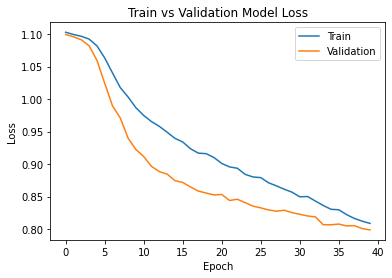

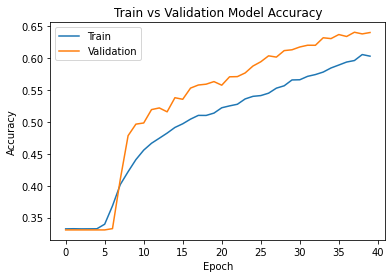


Calculating metrics...
Accuracy: 0.6492842535787321
Precision: [0.74678899 0.63570336 0.56292683]
Recall: [0.71340929 0.72874671 0.50569676]
F1 score: [0.72971762 0.67905267 0.53277932]
Support: [2282 2282 2282]
              precision    recall  f1-score   support

         0.0       0.75      0.71      0.73      2282
         1.0       0.64      0.73      0.68      2282
         2.0       0.56      0.51      0.53      2282

    accuracy                           0.65      6846
   macro avg       0.65      0.65      0.65      6846
weighted avg       0.65      0.65      0.65      6846



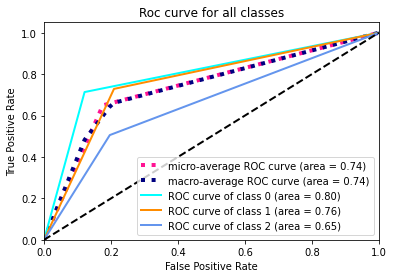

In [49]:
train_evaluate_bidirectional_RNN_model_LSTM(TEXT, train_data, valid_data)

**BIDIRECTIONAL STACKED RNN WITH GRU**

BIDIRECTIONAL_RNN_LSTM_GRU(
  (word_embeddings): Embedding(20872, 25, padding_idx=1)
  (rnn): GRU(25, 20, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (predictor): Linear(in_features=40, out_features=3, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (relu): ReLU()
)
The model has 535,003 trainable parameters


100%|██████████| 27/27 [00:00<00:00, 85.87it/s] 


Epoch: 01 | Epoch Time: 0m 7s
	Train Loss: 1.108 | Train Acc: 33.29%
	 Val. Loss: 1.095 |  Val. Acc: 33.06%


100%|██████████| 27/27 [00:00<00:00, 83.66it/s]


Epoch: 02 | Epoch Time: 0m 8s
	Train Loss: 1.099 | Train Acc: 33.33%
	 Val. Loss: 1.088 |  Val. Acc: 33.06%


100%|██████████| 27/27 [00:00<00:00, 90.02it/s] 


Epoch: 03 | Epoch Time: 0m 8s
	Train Loss: 1.093 | Train Acc: 33.35%
	 Val. Loss: 1.081 |  Val. Acc: 33.06%


100%|██████████| 27/27 [00:00<00:00, 78.10it/s]


Epoch: 04 | Epoch Time: 0m 8s
	Train Loss: 1.087 | Train Acc: 33.36%
	 Val. Loss: 1.071 |  Val. Acc: 33.06%


100%|██████████| 27/27 [00:00<00:00, 87.76it/s] 


Epoch: 05 | Epoch Time: 0m 7s
	Train Loss: 1.077 | Train Acc: 33.62%
	 Val. Loss: 1.053 |  Val. Acc: 33.06%


100%|██████████| 27/27 [00:00<00:00, 89.58it/s] 


Epoch: 06 | Epoch Time: 0m 7s
	Train Loss: 1.061 | Train Acc: 34.87%
	 Val. Loss: 1.022 |  Val. Acc: 35.40%


100%|██████████| 27/27 [00:00<00:00, 89.72it/s] 


Epoch: 07 | Epoch Time: 0m 7s
	Train Loss: 1.039 | Train Acc: 37.72%
	 Val. Loss: 0.990 |  Val. Acc: 45.81%


100%|██████████| 27/27 [00:00<00:00, 87.80it/s] 


Epoch: 08 | Epoch Time: 0m 7s
	Train Loss: 1.016 | Train Acc: 41.30%
	 Val. Loss: 0.956 |  Val. Acc: 49.50%


100%|██████████| 27/27 [00:00<00:00, 87.38it/s] 


Epoch: 09 | Epoch Time: 0m 7s
	Train Loss: 0.999 | Train Acc: 43.59%
	 Val. Loss: 0.942 |  Val. Acc: 52.87%


100%|██████████| 27/27 [00:00<00:00, 87.66it/s] 


Epoch: 10 | Epoch Time: 0m 7s
	Train Loss: 0.984 | Train Acc: 45.43%
	 Val. Loss: 0.920 |  Val. Acc: 53.96%


100%|██████████| 27/27 [00:00<00:00, 86.96it/s] 


Epoch: 11 | Epoch Time: 0m 7s
	Train Loss: 0.973 | Train Acc: 46.45%
	 Val. Loss: 0.908 |  Val. Acc: 54.44%


100%|██████████| 27/27 [00:00<00:00, 89.69it/s] 


Epoch: 12 | Epoch Time: 0m 7s
	Train Loss: 0.962 | Train Acc: 47.51%
	 Val. Loss: 0.907 |  Val. Acc: 54.40%


100%|██████████| 27/27 [00:00<00:00, 87.83it/s] 


Epoch: 13 | Epoch Time: 0m 7s
	Train Loss: 0.953 | Train Acc: 48.25%
	 Val. Loss: 0.901 |  Val. Acc: 54.68%


100%|██████████| 27/27 [00:00<00:00, 89.05it/s] 


Epoch: 14 | Epoch Time: 0m 7s
	Train Loss: 0.946 | Train Acc: 48.97%
	 Val. Loss: 0.892 |  Val. Acc: 54.69%


100%|██████████| 27/27 [00:00<00:00, 90.27it/s] 


Epoch: 15 | Epoch Time: 0m 7s
	Train Loss: 0.939 | Train Acc: 49.37%
	 Val. Loss: 0.887 |  Val. Acc: 54.82%


100%|██████████| 27/27 [00:00<00:00, 88.62it/s] 


Epoch: 16 | Epoch Time: 0m 7s
	Train Loss: 0.930 | Train Acc: 49.95%
	 Val. Loss: 0.883 |  Val. Acc: 55.10%


100%|██████████| 27/27 [00:00<00:00, 87.66it/s] 


Epoch: 17 | Epoch Time: 0m 7s
	Train Loss: 0.926 | Train Acc: 50.25%
	 Val. Loss: 0.880 |  Val. Acc: 55.14%


100%|██████████| 27/27 [00:00<00:00, 87.36it/s] 


Epoch: 18 | Epoch Time: 0m 7s
	Train Loss: 0.918 | Train Acc: 50.84%
	 Val. Loss: 0.874 |  Val. Acc: 55.37%


100%|██████████| 27/27 [00:00<00:00, 87.54it/s] 


Epoch: 19 | Epoch Time: 0m 7s
	Train Loss: 0.918 | Train Acc: 50.91%
	 Val. Loss: 0.872 |  Val. Acc: 55.62%


100%|██████████| 27/27 [00:00<00:00, 87.72it/s] 


Epoch: 20 | Epoch Time: 0m 7s
	Train Loss: 0.909 | Train Acc: 51.44%
	 Val. Loss: 0.867 |  Val. Acc: 55.99%


100%|██████████| 27/27 [00:00<00:00, 86.06it/s] 


Epoch: 21 | Epoch Time: 0m 7s
	Train Loss: 0.908 | Train Acc: 51.45%
	 Val. Loss: 0.863 |  Val. Acc: 56.08%


100%|██████████| 27/27 [00:00<00:00, 88.14it/s] 


Epoch: 22 | Epoch Time: 0m 7s
	Train Loss: 0.901 | Train Acc: 51.75%
	 Val. Loss: 0.861 |  Val. Acc: 56.25%


100%|██████████| 27/27 [00:00<00:00, 87.79it/s] 


Epoch: 23 | Epoch Time: 0m 7s
	Train Loss: 0.895 | Train Acc: 52.08%
	 Val. Loss: 0.857 |  Val. Acc: 56.49%


100%|██████████| 27/27 [00:00<00:00, 87.33it/s] 


Epoch: 24 | Epoch Time: 0m 7s
	Train Loss: 0.893 | Train Acc: 52.44%
	 Val. Loss: 0.852 |  Val. Acc: 56.76%


100%|██████████| 27/27 [00:00<00:00, 37.86it/s]


Epoch: 25 | Epoch Time: 0m 8s
	Train Loss: 0.886 | Train Acc: 52.84%
	 Val. Loss: 0.848 |  Val. Acc: 56.89%


100%|██████████| 27/27 [00:00<00:00, 72.44it/s]


Epoch: 26 | Epoch Time: 0m 8s
	Train Loss: 0.880 | Train Acc: 53.05%
	 Val. Loss: 0.845 |  Val. Acc: 57.48%


100%|██████████| 27/27 [00:00<00:00, 78.12it/s]


Epoch: 27 | Epoch Time: 0m 8s
	Train Loss: 0.880 | Train Acc: 53.08%
	 Val. Loss: 0.842 |  Val. Acc: 57.22%


100%|██████████| 27/27 [00:00<00:00, 81.99it/s] 


Epoch: 28 | Epoch Time: 0m 9s
	Train Loss: 0.875 | Train Acc: 53.64%
	 Val. Loss: 0.836 |  Val. Acc: 57.63%


100%|██████████| 27/27 [00:00<00:00, 87.85it/s] 


Epoch: 29 | Epoch Time: 0m 7s
	Train Loss: 0.869 | Train Acc: 54.00%
	 Val. Loss: 0.833 |  Val. Acc: 58.02%


100%|██████████| 27/27 [00:00<00:00, 87.87it/s] 


Epoch: 30 | Epoch Time: 0m 7s
	Train Loss: 0.863 | Train Acc: 54.64%
	 Val. Loss: 0.828 |  Val. Acc: 58.60%


100%|██████████| 27/27 [00:00<00:00, 90.57it/s] 


Epoch: 31 | Epoch Time: 0m 7s
	Train Loss: 0.860 | Train Acc: 55.01%
	 Val. Loss: 0.826 |  Val. Acc: 59.16%


100%|██████████| 27/27 [00:00<00:00, 87.48it/s] 


Epoch: 32 | Epoch Time: 0m 7s
	Train Loss: 0.857 | Train Acc: 54.85%
	 Val. Loss: 0.822 |  Val. Acc: 59.42%


100%|██████████| 27/27 [00:00<00:00, 88.38it/s] 


Epoch: 33 | Epoch Time: 0m 7s
	Train Loss: 0.850 | Train Acc: 55.78%
	 Val. Loss: 0.817 |  Val. Acc: 60.09%


100%|██████████| 27/27 [00:00<00:00, 91.55it/s] 


Epoch: 34 | Epoch Time: 0m 7s
	Train Loss: 0.843 | Train Acc: 56.24%
	 Val. Loss: 0.813 |  Val. Acc: 60.71%


100%|██████████| 27/27 [00:00<00:00, 86.85it/s] 


Epoch: 35 | Epoch Time: 0m 7s
	Train Loss: 0.843 | Train Acc: 56.52%
	 Val. Loss: 0.813 |  Val. Acc: 60.59%


100%|██████████| 27/27 [00:00<00:00, 88.54it/s] 


Epoch: 36 | Epoch Time: 0m 7s
	Train Loss: 0.837 | Train Acc: 57.19%
	 Val. Loss: 0.807 |  Val. Acc: 61.01%


100%|██████████| 27/27 [00:00<00:00, 87.25it/s] 


Epoch: 37 | Epoch Time: 0m 7s
	Train Loss: 0.829 | Train Acc: 57.93%
	 Val. Loss: 0.804 |  Val. Acc: 61.11%


100%|██████████| 27/27 [00:00<00:00, 88.23it/s] 


Epoch: 38 | Epoch Time: 0m 7s
	Train Loss: 0.823 | Train Acc: 58.28%
	 Val. Loss: 0.800 |  Val. Acc: 61.49%


100%|██████████| 27/27 [00:00<00:00, 88.01it/s] 


Epoch: 39 | Epoch Time: 0m 7s
	Train Loss: 0.817 | Train Acc: 58.88%
	 Val. Loss: 0.795 |  Val. Acc: 61.62%


100%|██████████| 27/27 [00:00<00:00, 87.03it/s] 


Epoch: 40 | Epoch Time: 0m 7s
	Train Loss: 0.816 | Train Acc: 59.21%
	 Val. Loss: 0.789 |  Val. Acc: 62.63%


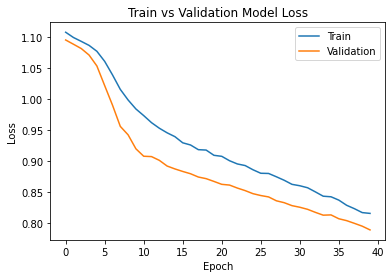

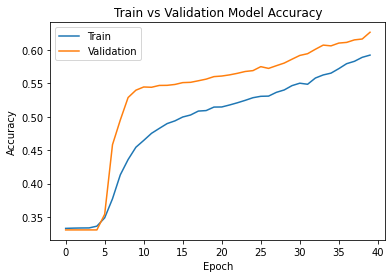


Calculating metrics...
Accuracy: 0.6478235465965527
Precision: [0.77860327 0.60431412 0.57526882]
Recall: [0.68886941 0.78571429 0.46888694]
F1 score: [0.73099279 0.68317775 0.51665862]
Support: [2282 2282 2282]
              precision    recall  f1-score   support

         0.0       0.78      0.69      0.73      2282
         1.0       0.60      0.79      0.68      2282
         2.0       0.58      0.47      0.52      2282

    accuracy                           0.65      6846
   macro avg       0.65      0.65      0.64      6846
weighted avg       0.65      0.65      0.64      6846



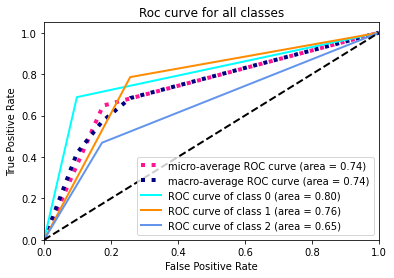

In [53]:
train_evaluate_bidirectional_RNN_model_GRU(TEXT, train_data, valid_data)

**2. ADDING ATTENTION TO THE BEST MODEL**

In [55]:
class BIDIRECTIONAL_RNN_LSTM_GRU_ATTENTION(nn.Module):
  
  def __init__(self, cell_type, input_size, embedding_size, hidden_size, output_size, embeddings, num_layers, dropout, pad_idx):
    super(BIDIRECTIONAL_RNN_LSTM_GRU_ATTENTION, self).__init__()

    cells = {'LSTM': nn.LSTM, 'GRU': nn.GRU}   

    # Initializations
    self.cell_type = cell_type
    self.input_size = input_size
    self.embedding_size = embedding_size
    self.hidden_size = hidden_size
    self.output_size = output_size  
    self.num_layers = num_layers
    self.dropout = dropout
          
    # Feed the tweets in the embedding layer
    # padding_idx set to not learn the embedding for the <pad> token - irrelevant to determining sentiment 
    self.word_embeddings = nn.Embedding(input_size, embedding_size, padding_idx = pad_idx)
    
    
    assert cell_type in cells, 'Use one of the following: {}'.format(str(cells))
    rnn_cell = getattr(nn, cell_type) # It fetches the constructor from torch.nn
    self.rnn = rnn_cell(
        input_size = self.embedding_size,   # Number of features for each time step        
        num_layers = self.num_layers,       # If the number of layers is bigger than 1, then it is a stacked RNN)
        hidden_size = self.hidden_size,     # LSTM/GRU hidden embedding representation
        batch_first = True,                 # Input and output's batch size: (batch, time_step, input_size) => 1st dimension
        bidirectional = True,               # It is a bidirectional RNN
        dropout = self.dropout)             # Dropout regularization  
                
    # Final hidden state has both a forward and a backward component concatenated together
    # The size of the input to the nn.Linear layer is twice that of the hidden dimension size
    self.predictor = nn.Linear(hidden_size*2, output_size)

    # Initialize dropout layer for regularization
    self.dropout = nn.Dropout(dropout)

    # Initialize RELU activation function
    self.relu = nn.ReLU()

  def attention(self, output, final_state):
    
    # output : The final output of the RNN which contains hidden layer outputs for each sequence
    # final_state : The final time-step hidden state (h_n) of the RNN

    # It computes the weights for each sequence in the output 
    # and then computes the new hidden state

    # Use torch.bmm for batch matrix multiplication
    attn_weights = torch.bmm(output, final_state.unsqueeze(2)).squeeze(2)
    soft_attn_weights = F.softmax(attn_weights, 1).unsqueeze(2)       
    new_hidden_state = torch.bmm(output.transpose(1, 2), soft_attn_weights).squeeze(2)

    return new_hidden_state      
     
  def forward(self, text, text_lengths):
        
    # Text - [tweet length, batch size]
    # Text_lengths - lengths of tweet
        
    # Embedded = [sentence len, batch size, emb dim] with dropout 
    embedded = self.dropout(self.word_embeddings(text))    

    # Pack the embeddings to only process non-padded elements, it speeds up computation
    packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.to('cpu'))

    if self.cell_type == 'LSTM':
      packed_output, (hidden, cell) = self.rnn(packed_embedded)
    if self.cell_type == 'GRU':
      packed_output, hidden = self.rnn(packed_embedded)

    # Unpack the sequence - transform packed sequence to a tensor
    output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)

    output = output.permute(1, 0, 2) 
   
    # Get the final layer forward and backward hidden states  
    # Concat the final forward and backward hidden layers and apply dropout
    hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
    
    # Add attention 
    attn_output = self.attention(output, hidden)
  
    # Output = [sentence len, batch size, hid dim * num directions]
    # Output over padding tokens are zero tensors
        
    # Hidden = [num layers * num directions, batch size, hid dim]
    # Cell = [num layers * num directions, batch size, hid dim]
 
    return self.predictor(self.relu(attn_output))

In [56]:
# STACKED RNN + ATTENTION mechanism (Best model from the previous ones)
def train_evaluate_bidirectional_RNN_model_ATTENTION(TEXT, data_train, data_val):
  
  # -----Initialize the model and its parameters-----
  # The number of words in the vocabulary
  input_dim = len(TEXT.vocab)
  # The dimensions of each Glove vector              
  embedding_dim = 25                       
  # The number of hidden neurons
  hidden_dim = 20                     
  # The number of output layers
  output_dim = 3                           
  # The number of hidden layers
  num_layers = 2                                           
  # Cell type of model
  cell_type = 'LSTM'                       
  # Dropout
  dropout = 0.5                
  # The Glove pre-trained embeddings
  embeddings = TEXT.vocab.vectors          
  # Get pad token index from vocab
  PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

  # Initialize the model parameters
  num_epochs = 40
  batch_size = 256
  clip = 2
    
  # Instantiate the model 
  model = BIDIRECTIONAL_RNN_LSTM_GRU_ATTENTION(cell_type, input_dim, embedding_dim, hidden_dim, output_dim, embeddings, num_layers, dropout, PAD_IDX)
  print(model)
  model = model.to(device)
  print(f'The model has {count_parameters(model):,} trainable parameters')

  # Replace the initial weights of the embedding layer with the pre-trained embeddings
  model.word_embeddings.weight.data.copy_(embeddings)
  # Initialize <unk> and <pad> both to all zeros - irrelevant for sentiment analysis
  UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

  # Setting row in the embedding weights matrix to zero using the token index
  model.word_embeddings.weight.data[UNK_IDX] = torch.zeros(embedding_dim)
  model.word_embeddings.weight.data[PAD_IDX] = torch.zeros(embedding_dim)
  #print(model.embedding.weight.data)

  # Define the optimizer
  optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001, weight_decay = 1e-4)   
  
  # Define loss function
  loss_function = nn.CrossEntropyLoss()
  loss_function = loss_function.to(device)

  # Create the iterators used for training and evaluating the model
  train_iterator, valid_iterator = create_iterators(data_train, data_val, batch_size)

  best_valid_loss = float('inf')

  # Initialize empty lists to store the values of loss and accuracy for each epoch
  train_accuracies = []
  train_losses = []
  val_accuracies = []
  val_losses = []
  
  for epoch in range(num_epochs):
    
    start_time = time.time()

    train_loss, train_accuracy = train(model, train_iterator, optimizer, loss_function, clip)
    validation_loss, validation_accuracy = evaluate(model, valid_iterator, loss_function)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
      
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_accuracy*100:.2f}%')
    print(f'\t Val. Loss: {validation_loss:.3f} |  Val. Acc: {validation_accuracy*100:.2f}%')
      
    if validation_loss < best_valid_loss:
        best_valid_loss = validation_loss
        torch.save(model.state_dict(), 'GRU_ATTENTION_model.pt')

    # Fill the empty lists with the values of accuracy and loss for training and evaluation sets
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(validation_loss)
    val_accuracies.append(validation_accuracy)

  # Plot the loss vs epochs 
  plt.plot(train_losses)
  plt.plot(val_losses)
  plt.title('Train vs Validation Model Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'])
  plt.show()

  # Plot the accuracy vs epochs
  plt.plot(train_accuracies)
  plt.plot(val_accuracies)
  plt.title('Train vs Validation Model Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'])
  plt.show()

  # Evaluate model on the validation set
  predictions, labels = testing(model, valid_iterator)

  # Calculate the evaluation metrics on the testing set    
  calculate_metrics(labels, predictions)                        

  # Label binarization and store the number of classes
  y_test = label_binarize(labels, classes=[0, 1, 2])
  n_classes = y_test.shape[1]

  # Label binarization and store the number of classes
  y_score = label_binarize(predictions, classes=[0, 1, 2])

  # Compute ROC curve and ROC area for each class
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

  # Compute micro-average ROC curve and ROC area
  fpr['micro'], tpr['micro'], _ = roc_curve(y_test.ravel(), y_score.ravel())
  roc_auc['micro'] = auc(fpr['micro'], tpr['micro'])

  # First aggregate all false positive rates
  all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

  # Then interpolate all ROC curves at this points
  mean_tpr = np.zeros_like(all_fpr)
  for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

  # Finally average it and compute AUC
  mean_tpr /= n_classes

  fpr['macro'] = all_fpr
  tpr['macro'] = mean_tpr
  roc_auc['macro'] = auc(fpr['macro'], tpr['macro'])
  lw = 2

  # Plot all ROC curves
  plt.figure()
  plt.plot(
    fpr['micro'],
    tpr['micro'],
    label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc['micro']),
    color='deeppink',
    linestyle=':',
    linewidth=4,)

  plt.plot(
    fpr['macro'],
    tpr['macro'],
    label='macro-average ROC curve (area = {0:0.2f})'.format(roc_auc['macro']),
    color='navy',
    linestyle=':',
    linewidth=4,)

  colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
  for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label= 'ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]),)

  plt.plot([0, 1], [0, 1], "k--", lw=lw)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Roc curve for all classes')
  plt.legend(loc='lower right')
  plt.show()

**BIDIRECTIONAL STACKED RNN WITH GRU & ATTENTION**

BIDIRECTIONAL_RNN_LSTM_GRU_ATTENTION(
  (word_embeddings): Embedding(20872, 25, padding_idx=1)
  (rnn): LSTM(25, 20, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (predictor): Linear(in_features=40, out_features=3, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (relu): ReLU()
)
The model has 539,363 trainable parameters


100%|██████████| 27/27 [00:00<00:00, 83.67it/s] 


Epoch: 01 | Epoch Time: 0m 6s
	Train Loss: 1.098 | Train Acc: 33.22%
	 Val. Loss: 1.095 |  Val. Acc: 33.06%


100%|██████████| 27/27 [00:00<00:00, 86.08it/s] 


Epoch: 02 | Epoch Time: 0m 6s
	Train Loss: 1.094 | Train Acc: 33.25%
	 Val. Loss: 1.089 |  Val. Acc: 33.06%


100%|██████████| 27/27 [00:00<00:00, 86.83it/s] 


Epoch: 03 | Epoch Time: 0m 6s
	Train Loss: 1.087 | Train Acc: 33.22%
	 Val. Loss: 1.071 |  Val. Acc: 33.06%


100%|██████████| 27/27 [00:00<00:00, 85.16it/s] 


Epoch: 04 | Epoch Time: 0m 7s
	Train Loss: 1.062 | Train Acc: 33.23%
	 Val. Loss: 1.015 |  Val. Acc: 33.34%


100%|██████████| 27/27 [00:00<00:00, 85.32it/s] 


Epoch: 05 | Epoch Time: 0m 6s
	Train Loss: 1.025 | Train Acc: 35.81%
	 Val. Loss: 0.971 |  Val. Acc: 47.34%


100%|██████████| 27/27 [00:00<00:00, 84.91it/s] 


Epoch: 06 | Epoch Time: 0m 6s
	Train Loss: 0.997 | Train Acc: 43.10%
	 Val. Loss: 0.941 |  Val. Acc: 50.83%


100%|██████████| 27/27 [00:00<00:00, 85.59it/s] 


Epoch: 07 | Epoch Time: 0m 6s
	Train Loss: 0.978 | Train Acc: 46.06%
	 Val. Loss: 0.926 |  Val. Acc: 54.36%


100%|██████████| 27/27 [00:00<00:00, 84.22it/s] 


Epoch: 08 | Epoch Time: 0m 6s
	Train Loss: 0.963 | Train Acc: 48.02%
	 Val. Loss: 0.907 |  Val. Acc: 56.15%


100%|██████████| 27/27 [00:00<00:00, 86.31it/s] 


Epoch: 09 | Epoch Time: 0m 6s
	Train Loss: 0.951 | Train Acc: 49.47%
	 Val. Loss: 0.898 |  Val. Acc: 57.84%


100%|██████████| 27/27 [00:00<00:00, 82.14it/s]


Epoch: 10 | Epoch Time: 0m 6s
	Train Loss: 0.940 | Train Acc: 51.14%
	 Val. Loss: 0.890 |  Val. Acc: 58.53%


100%|██████████| 27/27 [00:00<00:00, 85.66it/s] 


Epoch: 11 | Epoch Time: 0m 6s
	Train Loss: 0.929 | Train Acc: 52.18%
	 Val. Loss: 0.879 |  Val. Acc: 58.92%


100%|██████████| 27/27 [00:00<00:00, 83.62it/s] 


Epoch: 12 | Epoch Time: 0m 6s
	Train Loss: 0.921 | Train Acc: 52.67%
	 Val. Loss: 0.876 |  Val. Acc: 59.89%


100%|██████████| 27/27 [00:00<00:00, 85.15it/s] 


Epoch: 13 | Epoch Time: 0m 6s
	Train Loss: 0.912 | Train Acc: 53.82%
	 Val. Loss: 0.871 |  Val. Acc: 59.95%


100%|██████████| 27/27 [00:00<00:00, 85.78it/s] 


Epoch: 14 | Epoch Time: 0m 6s
	Train Loss: 0.901 | Train Acc: 54.71%
	 Val. Loss: 0.861 |  Val. Acc: 60.62%


100%|██████████| 27/27 [00:00<00:00, 86.91it/s] 


Epoch: 15 | Epoch Time: 0m 6s
	Train Loss: 0.897 | Train Acc: 55.32%
	 Val. Loss: 0.856 |  Val. Acc: 61.08%


100%|██████████| 27/27 [00:00<00:00, 86.97it/s] 


Epoch: 16 | Epoch Time: 0m 6s
	Train Loss: 0.888 | Train Acc: 55.75%
	 Val. Loss: 0.845 |  Val. Acc: 60.72%


100%|██████████| 27/27 [00:00<00:00, 85.48it/s] 


Epoch: 17 | Epoch Time: 0m 6s
	Train Loss: 0.881 | Train Acc: 56.53%
	 Val. Loss: 0.842 |  Val. Acc: 61.39%


100%|██████████| 27/27 [00:00<00:00, 84.19it/s] 


Epoch: 18 | Epoch Time: 0m 6s
	Train Loss: 0.876 | Train Acc: 56.63%
	 Val. Loss: 0.838 |  Val. Acc: 61.62%


100%|██████████| 27/27 [00:00<00:00, 84.61it/s] 


Epoch: 19 | Epoch Time: 0m 6s
	Train Loss: 0.865 | Train Acc: 57.45%
	 Val. Loss: 0.832 |  Val. Acc: 61.85%


100%|██████████| 27/27 [00:00<00:00, 82.45it/s] 


Epoch: 20 | Epoch Time: 0m 6s
	Train Loss: 0.863 | Train Acc: 57.71%
	 Val. Loss: 0.826 |  Val. Acc: 62.16%


100%|██████████| 27/27 [00:00<00:00, 85.13it/s] 


Epoch: 21 | Epoch Time: 0m 6s
	Train Loss: 0.854 | Train Acc: 58.33%
	 Val. Loss: 0.823 |  Val. Acc: 62.59%


100%|██████████| 27/27 [00:00<00:00, 84.07it/s] 


Epoch: 22 | Epoch Time: 0m 6s
	Train Loss: 0.848 | Train Acc: 58.93%
	 Val. Loss: 0.819 |  Val. Acc: 62.84%


100%|██████████| 27/27 [00:00<00:00, 83.00it/s]


Epoch: 23 | Epoch Time: 0m 6s
	Train Loss: 0.841 | Train Acc: 59.40%
	 Val. Loss: 0.814 |  Val. Acc: 62.81%


100%|██████████| 27/27 [00:00<00:00, 84.83it/s] 


Epoch: 24 | Epoch Time: 0m 6s
	Train Loss: 0.835 | Train Acc: 59.81%
	 Val. Loss: 0.810 |  Val. Acc: 63.84%


100%|██████████| 27/27 [00:00<00:00, 83.31it/s] 


Epoch: 25 | Epoch Time: 0m 6s
	Train Loss: 0.830 | Train Acc: 60.47%
	 Val. Loss: 0.806 |  Val. Acc: 64.14%


100%|██████████| 27/27 [00:00<00:00, 85.00it/s] 


Epoch: 26 | Epoch Time: 0m 6s
	Train Loss: 0.824 | Train Acc: 60.68%
	 Val. Loss: 0.802 |  Val. Acc: 64.48%


100%|██████████| 27/27 [00:00<00:00, 83.73it/s] 


Epoch: 27 | Epoch Time: 0m 6s
	Train Loss: 0.817 | Train Acc: 61.04%
	 Val. Loss: 0.803 |  Val. Acc: 64.30%


100%|██████████| 27/27 [00:00<00:00, 83.61it/s] 


Epoch: 28 | Epoch Time: 0m 6s
	Train Loss: 0.815 | Train Acc: 61.21%
	 Val. Loss: 0.799 |  Val. Acc: 64.25%


100%|██████████| 27/27 [00:00<00:00, 85.10it/s] 


Epoch: 29 | Epoch Time: 0m 6s
	Train Loss: 0.810 | Train Acc: 61.46%
	 Val. Loss: 0.796 |  Val. Acc: 64.30%


100%|██████████| 27/27 [00:00<00:00, 85.19it/s] 


Epoch: 30 | Epoch Time: 0m 6s
	Train Loss: 0.802 | Train Acc: 62.21%
	 Val. Loss: 0.796 |  Val. Acc: 63.58%


100%|██████████| 27/27 [00:00<00:00, 82.73it/s]


Epoch: 31 | Epoch Time: 0m 6s
	Train Loss: 0.798 | Train Acc: 62.29%
	 Val. Loss: 0.791 |  Val. Acc: 65.14%


100%|██████████| 27/27 [00:00<00:00, 84.26it/s] 


Epoch: 32 | Epoch Time: 0m 6s
	Train Loss: 0.792 | Train Acc: 62.77%
	 Val. Loss: 0.790 |  Val. Acc: 65.44%


100%|██████████| 27/27 [00:00<00:00, 85.69it/s] 


Epoch: 33 | Epoch Time: 0m 6s
	Train Loss: 0.790 | Train Acc: 63.22%
	 Val. Loss: 0.786 |  Val. Acc: 65.35%


100%|██████████| 27/27 [00:00<00:00, 86.40it/s] 


Epoch: 34 | Epoch Time: 0m 6s
	Train Loss: 0.783 | Train Acc: 63.45%
	 Val. Loss: 0.784 |  Val. Acc: 65.35%


100%|██████████| 27/27 [00:00<00:00, 85.79it/s] 


Epoch: 35 | Epoch Time: 0m 6s
	Train Loss: 0.780 | Train Acc: 63.73%
	 Val. Loss: 0.785 |  Val. Acc: 65.69%


100%|██████████| 27/27 [00:00<00:00, 83.88it/s] 


Epoch: 36 | Epoch Time: 0m 6s
	Train Loss: 0.774 | Train Acc: 64.03%
	 Val. Loss: 0.778 |  Val. Acc: 65.48%


100%|██████████| 27/27 [00:00<00:00, 86.57it/s] 


Epoch: 37 | Epoch Time: 0m 6s
	Train Loss: 0.768 | Train Acc: 64.65%
	 Val. Loss: 0.779 |  Val. Acc: 65.55%


100%|██████████| 27/27 [00:00<00:00, 83.60it/s] 


Epoch: 38 | Epoch Time: 0m 6s
	Train Loss: 0.764 | Train Acc: 64.53%
	 Val. Loss: 0.773 |  Val. Acc: 65.68%


100%|██████████| 27/27 [00:00<00:00, 84.77it/s] 


Epoch: 39 | Epoch Time: 0m 6s
	Train Loss: 0.756 | Train Acc: 65.10%
	 Val. Loss: 0.774 |  Val. Acc: 65.67%


100%|██████████| 27/27 [00:00<00:00, 85.76it/s] 


Epoch: 40 | Epoch Time: 0m 6s
	Train Loss: 0.752 | Train Acc: 65.72%
	 Val. Loss: 0.770 |  Val. Acc: 65.41%


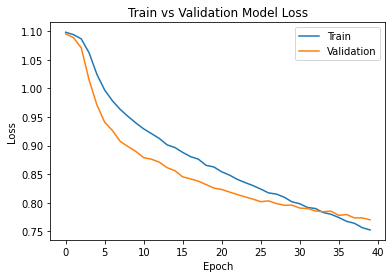

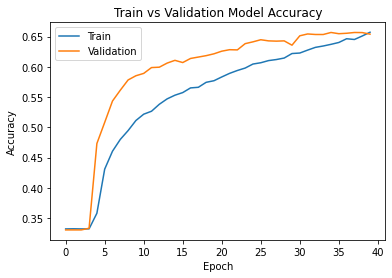


Calculating metrics...
Accuracy: 0.6545427987145779
Precision: [0.76441597 0.65323618 0.56602254]
Recall: [0.67966696 0.66783523 0.61612621]
F1 score: [0.71955463 0.66045504 0.59001259]
Support: [2282 2282 2282]
              precision    recall  f1-score   support

         0.0       0.76      0.68      0.72      2282
         1.0       0.65      0.67      0.66      2282
         2.0       0.57      0.62      0.59      2282

    accuracy                           0.65      6846
   macro avg       0.66      0.65      0.66      6846
weighted avg       0.66      0.65      0.66      6846



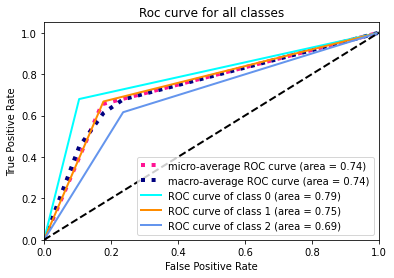

In [57]:
train_evaluate_bidirectional_RNN_model_ATTENTION(TEXT, train_data, valid_data)